In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step 1. 데이터 불러오기
   

In [32]:
data_dir = os.getenv("HOME") + '/aiffel/DATA'
tokenizer_name = 'spm'

In [33]:
# # train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA/pickle' # 파일 경로 지정
data_train_path = data_dir+f"/data_train_{tokenizer_name}_16000_0324.pkl"
data_test_path = data_dir+f"/data_test_{tokenizer_name}_16000_0324.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')

In [34]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948219 entries, 0 to 949887
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   reg       948219 non-null  object
 1   topic     948219 non-null  object
 2   stdn      948219 non-null  object
 3   dial      948219 non-null  object
 4   eng       948219 non-null  object
 5   toks_en   948219 non-null  object
 6   toks_dec  948219 non-null  object
dtypes: object(7)
memory usage: 57.9+ MB


In [35]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 39379 to 297204
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       125 non-null    object
 1   topic     125 non-null    object
 2   stdn      125 non-null    object
 3   dial      125 non-null    object
 4   eng       125 non-null    object
 5   toks_en   125 non-null    object
 6   toks_dec  125 non-null    object
dtypes: object(7)
memory usage: 7.8+ KB


In [36]:
regs = full_data.reg.unique()

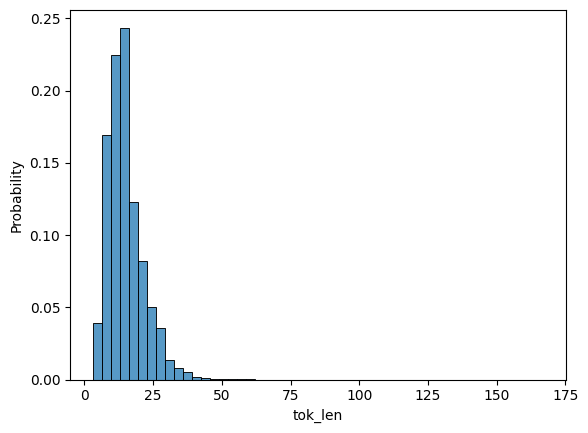

In [37]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_en'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [38]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    17.258820
gs    16.009518
jd    16.796067
jj    13.125946
kw    13.556690
Name: tok_len, dtype: float64

In [39]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.9,0.9999,1],labels =[1,2,3])

In [40]:
len(full_data.loc[full_data['tok_cat']==3,'tok_len'])

90

In [41]:
full_data.loc[full_data['tok_cat']==3,'tok_len'].agg([min,max])

min     66
max    167
Name: tok_len, dtype: int64

In [42]:
data_path = os.getenv('HOME') + '/aiffel/saturi/notebook/Preprocessing/'
sizes = 16009
SRC_VOCAB_SIZE = sizes
TGT_VOCAB_SIZE = sizes

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_spm16000.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+f'spm_dec_{tokenizer_name}16000.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델불러오기

In [43]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [44]:
#wandb 설정
warmups = 8500
project_name = f'model_exp_{tokenizer_name}_16000_0329_final_최종cc'
run  = wandb.init(project = project_name ,
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer',
                     'n_layers':6,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len': 512,
                     'dropout':0.2,
                     'shared':True,
                     'warmups' : warmups,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                 })
config = wandb.config

In [45]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [46]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [47]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [48]:
learningrate = LearningRateScheduler(512)

In [49]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [50]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [51]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [52]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [53]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric, translate
full_data = full_data.sample(frac=1).copy()

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        
        batch_size = 64
        buckets = iter(reversed(full_data['tok_cat'].unique().tolist()))

        for bucket in buckets :
            total_loss = 0     
            
            src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
            tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
            src_valid_corpus = full_data_test['toks_en'].values
            tgt_valid_corpus = full_data_test['toks_dec'].values
            max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()

            if max_len > 380 :
                batch_size = 8

            if max_len > 512 : 
                max_len = 512


            enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
            dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
            enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
            dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)
            
            idx_list = list(range(0, enc_train.shape[0], batch_size))
            random.shuffle(idx_list)

            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                             dec_train[idx:idx+batch_size],
                                                                             transformer,
                                                                             optimizer)

                total_loss += batch_loss

                t.set_description_str('Bucket %2d' % (bucket))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
                wandb.log({
                       "train_loss": (total_loss.numpy() / (batch + 1)),
                       })
            
            #validation
            total_loss_val = 0
            val_size=25
            tv = tqdm(range(0,enc_test.shape[0], val_size))
            
            for (batch_val,test_idx) in enumerate(tv) :
                val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + val_size],
                                          dec_test[test_idx : test_idx + val_size],
                                          transformer)
                total_loss_val += val_loss
                tv.set_postfix_str('val_Loss %.4f' % (total_loss_val.numpy() / (batch_val + 1)))
                
                wandb.log({
                           "valid_loss" : (total_loss_val.numpy() / (batch_val + 1))
                           })

            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
        # bleu score
        from datasets import load_metric

        bleu = load_metric("sacrebleu")
        test_translate = []
        bleu_valid_score = []
        
        test_text = full_data_test.eng.values
        test_tgt = full_data_test.dial.values
        
        for i in tqdm(range(len(test_text))) :
            trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
            test_translate.append(trans)
            label = dec_tokenizer.decode(test_tgt[i])
            result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
            bleu_valid_score.append(result)

        sum(bleu_valid_score)/len(test_text)
        wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

        full_data_test['bleu'] = np.array(bleu_valid_score)
        full_data_test['pred'] = test_translate
            
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +f'tf_{tokenizer_name}16000_ckpt_final_0329_최종',max_to_keep=6)

In [76]:
# import shutil
# dir_mo = os.getenv("HOME") + '/aiffel/MODEL'
# os.listdir(dir_mo)

In [77]:
# shutil.rmtree(dir_mo + '/##')

In [78]:
manager.latest_checkpoint

'/home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-21'

In [54]:
ckpt.restore(manager.latest_checkpoint)

## 학습

In [60]:
for _ in range(7):
    run  = wandb.init(project = project_name,
                     entity = 'saturi',
                     config = {
                         'model_name':'Vanilla_Transformer',
                         'n_layers':6,
                         'd_model':512,
                         'n_heads':8,
                         'd_ff':2048,
                         'src_vocab_size':SRC_VOCAB_SIZE,
                         'tgt_vocab_size':TGT_VOCAB_SIZE,
                         'pos_len': 512,
                         'dropout':0.2,
                         'shared':True,
                         'warmups' : warmups,
                         'epochs':1,
                         'optimizer' :'ADAM',
                         'loss' : 'SparseCategoricalCrossentropy',
                         'metric' : 'bleu'
                     })
    train_and_checkpoint(transformer, manager, config.epochs)

Initializing from scratch.


100%|███████████████████████████| 5/5 [00:02<00:00,  2.42it/s, val_Loss 11.1400]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-1


100%|████████████████████████████| 5/5 [00:01<00:00,  2.69it/s, val_Loss 5.1792]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-2


100%|████████████████████████████| 5/5 [00:01<00:00,  2.84it/s, val_Loss 3.4688]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-3


100%|█████████████████████████████████████████| 125/125 [03:57<00:00,  1.90s/it]


bleu,▁
train_loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█████▂▃▃▃▃▁▁▁▁▁
bleu,13.49475
train_loss,4.01946
valid_loss,3.46879


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-3


100%|████████████████████████████| 5/5 [00:00<00:00, 16.07it/s, val_Loss 3.6166]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-4


100%|████████████████████████████| 5/5 [00:00<00:00, 36.57it/s, val_Loss 3.3120]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-5


100%|████████████████████████████| 5/5 [00:00<00:00, 75.64it/s, val_Loss 3.1712]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-6


100%|█████████████████████████████████████████| 125/125 [04:10<00:00,  2.01s/it]


bleu,▁
train_loss,█▇▇▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▆▇█▇▆▁▄▄▃▃▂▂▃▂▁
bleu,14.48771
train_loss,3.15328
valid_loss,3.17121


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-6


100%|████████████████████████████| 5/5 [00:00<00:00, 16.10it/s, val_Loss 3.2199]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-7


100%|████████████████████████████| 5/5 [00:00<00:00, 37.07it/s, val_Loss 2.9666]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-8


100%|████████████████████████████| 5/5 [00:00<00:00, 76.50it/s, val_Loss 3.0164]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-9


100%|█████████████████████████████████████████| 125/125 [04:08<00:00,  1.98s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▇▇█▇▅▁▄▄▂▂▃▄▅▄▃
bleu,14.46051
train_loss,2.83516
valid_loss,3.01635


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-9


100%|████████████████████████████| 5/5 [00:00<00:00, 15.86it/s, val_Loss 3.0463]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-10


100%|████████████████████████████| 5/5 [00:00<00:00, 37.25it/s, val_Loss 2.8115]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-11


100%|████████████████████████████| 5/5 [00:00<00:00, 76.58it/s, val_Loss 2.9851]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-12


100%|█████████████████████████████████████████| 125/125 [04:06<00:00,  1.98s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▅▇█▆▅▁▄▄▂▂▄▆▆▅▄
bleu,13.57258
train_loss,2.63609
valid_loss,2.9851


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-12


100%|████████████████████████████| 5/5 [00:00<00:00, 15.97it/s, val_Loss 3.0402]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-13


100%|████████████████████████████| 5/5 [00:00<00:00, 36.61it/s, val_Loss 2.8034]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-14


100%|████████████████████████████| 5/5 [00:00<00:00, 77.55it/s, val_Loss 2.9712]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-15


100%|█████████████████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▅▆█▆▅▁▄▃▂▂▅▇▇▆▄
bleu,14.60063
train_loss,2.47421
valid_loss,2.97119


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-15


100%|████████████████████████████| 5/5 [00:00<00:00, 16.02it/s, val_Loss 3.0409]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-16


100%|████████████████████████████| 5/5 [00:00<00:00, 37.00it/s, val_Loss 2.7842]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-17


100%|████████████████████████████| 5/5 [00:00<00:00, 75.46it/s, val_Loss 3.0455]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-18


100%|█████████████████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▅▆█▇▅▁▄▄▂▁▅▇█▆▅
bleu,15.98425
train_loss,2.32973
valid_loss,3.04548


Restored from /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-18


100%|████████████████████████████| 5/5 [00:00<00:00, 16.00it/s, val_Loss 3.1103]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-19


100%|████████████████████████████| 5/5 [00:00<00:00, 36.76it/s, val_Loss 2.8204]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-20


100%|████████████████████████████| 5/5 [00:00<00:00, 75.93it/s, val_Loss 3.0612]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_msp16000_ckpt_final_0329_최종/ckpt-21


100%|█████████████████████████████████████████| 125/125 [04:05<00:00,  1.96s/it]


# Step 3. 평가

Text(0.5, 0, 'Train Step')

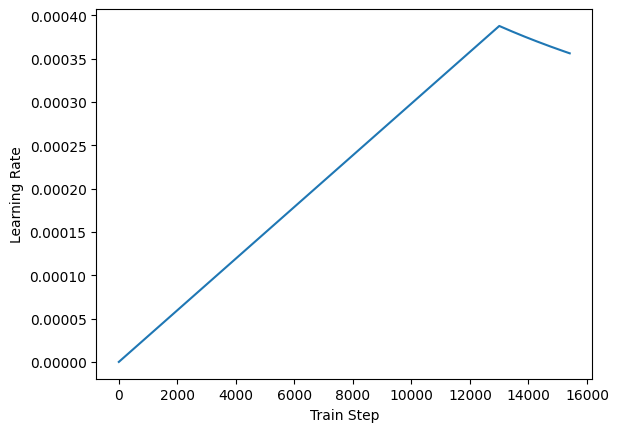

In [58]:
plt.plot(learningrate(tf.range(15412, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [26]:
from time import perf_counter

In [112]:
examples = ["<jj> what are you doing ?",'<cc> what are you doing ?','<gs> what are you doing ?','<jd> what are you doing ?','<kw> what are you doing ?']

In [110]:
examples = ["<jj> i like this song .",'<cc> i like this song . ','<gs> i like this song . ','<jd> i like this song . ','<kw> i like this song . ']

In [64]:
examples = ["<jj> Let's do homework together .","<cc> Let's do homework together .","<gs> Let's do homework together .","<jd> Let's do homework together .","<kw> Let's do homework together ."]

In [36]:
examples = ["<jj> Are you going to sleep ?","<cc> Are you going to sleep ?","<gs> Are you going to sleep ?","<jd> Are you going to sleep ?","<kw> Are you going to sleep ?"]

In [55]:
examples = ["<jj> I want to go out to eat .","<cc> I want to go out to eat .","<gs> I want to go out to eat .","<jd> I want to go out to eat .","<kw> I want to go out to eat ."]

In [56]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> I want to go out to eat .
Predicted translation: 밥 먹으래 나갈려고.
Input: <cc> I want to go out to eat .
Predicted translation: 아이 밥을 먹을라구 나가라 이 말이지.
Input: <gs> I want to go out to eat .
Predicted translation: 밥 무로 나갈라꼬.
Input: <jd> I want to go out to eat .
Predicted translation: 아이 밥을 먹을라 해.
Input: <kw> I want to go out to eat .
Predicted translation: 밥을 먹을라 이글세.
7.503337403999467


In [57]:
from datasets import load_metric

bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []

test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

100%|█████████████████████████████████████████| 125/125 [03:35<00:00,  1.72s/it]


In [29]:
full_data_test.bleu.mean()

15.273744047134048

In [30]:
full_data_test.loc[:,['topic','eng','reg','dial','pred','bleu']].sort_values('bleu', ascending=False).head()

,topic,eng,reg,dial,pred,bleu
802973,전자기기,<gs> <gs> Battery a little bit,gs,배터리 쫌,쫌 위험하꼬,70.710678
851942,스타일,<gs> <gs> Then you want me to do it,gs,그머 니가 원하느,그머 니가 한번,68.658905
922232,스타일,<jj> <jj> Isnt it so fun to watch things like ...,jj,이런 거 보는 거 너무 재밌주이 않?,이런 거 보는 거 너무 재미지메 않?,65.803701
308203,스포츠/레저,<kw> <kw> Where can you buy that?,kw,그건 어부어서 살 수 있습니까?,그건 어데서 살 수 있습니까?,63.894310
204242,종교,<jj> <jj> It was really good,jj,"진짜 맛있언,",진짜 맛 좋안,48.549177


In [31]:
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + f'/test_results_{tokenizer_name}16000_final_needs_merge_329.csv')

In [ ]:
wandb.finish()